In [1]:
# Cell 1 — Outbreak Agent Demo Notebook
# Paste each cell in order and run. This demo uses synthetic data and no API keys.
# Optional installs (usually not required on Kaggle). Uncomment if needed.
# !pip install prophet==1.1.3
# !pip install folium plotly scikit-learn


In [2]:
# Cell 2
import os
import random
import math
import datetime as dt
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support, brier_score_loss
import json
# Optional: seaborn for nicer plots; not required
import seaborn as sns
sns.set()
random.seed(42)
np.random.seed(42)


In [3]:
# Cell 3
REGIONS = [
    {"name": "Hyderabad", "lat": 17.3850, "lon": 78.4867},
    {"name": "Bengaluru", "lat": 12.9716, "lon": 77.5946},
    {"name": "Mumbai", "lat": 19.0760, "lon": 72.8777},
    {"name": "Chennai", "lat": 13.0827, "lon": 80.2707}
]

def now_ts():
    return dt.datetime.utcnow()

def to_date_str(ts):
    return ts.strftime("%Y-%m-%d")


In [4]:
# Cell 4
SYMPTOMS = ["fever", "cough", "headache", "nausea", "rash", "diarrhea", "fatigue", "sore throat"]

def generate_day_signals(date, region_name, base_rate=5, outbreak=False):
    items = []
    n = np.random.poisson(base_rate)
    if outbreak:
        n += np.random.poisson(15)
    for i in range(n):
        s = random.choice(SYMPTOMS)
        text = f"Patient reported {s} and {random.choice(['vomiting','dizziness','fever','cough'])} in {region_name}."
        severity = float(np.clip(np.random.normal(0.5, 0.2) + (s in ["fever","cough"])*0.2, 0, 1))
        items.append({
            "region": region_name,
            "date": date,
            "source": random.choice(["news","social","search"]),
            "text": text,
            "severity": severity
        })
    return items

def simulate_timeseries(start_date, days=120, outbreak_windows=None):
    records = []
    for r in REGIONS:
        region = r["name"]
        for d in range(days):
            date = start_date + dt.timedelta(days=d)
            outbreak = False
            if outbreak_windows and region in outbreak_windows:
                for (s,e) in outbreak_windows[region]:
                    if s <= d <= e:
                        outbreak = True
            items = generate_day_signals(date, region, base_rate=6, outbreak=outbreak)
            records.extend(items)
    df = pd.DataFrame(records)
    return df

# Example outbreak windows for demonstration
start_date = dt.date.today() - dt.timedelta(days=119)
outbreak_windows = {
    "Hyderabad":[(50,65)],
    "Mumbai":[(80,95)]
}
df_signals = simulate_timeseries(start_date, days=120, outbreak_windows=outbreak_windows)
print("Synthetic signals:", df_signals.shape)
df_signals.head()


Synthetic signals: (3309, 5)


,region,date,source,text,severity
0,Hyderabad,2025-07-29,search,Patient reported cough and vomiting in Hyderabad.,0.755808
1,Hyderabad,2025-07-29,news,Patient reported rash and dizziness in Hyderabad.,0.702103
2,Hyderabad,2025-07-29,search,Patient reported headache and vomiting in Hyde...,0.383824
3,Hyderabad,2025-07-29,news,Patient reported cough and cough in Hyderabad.,0.594966
4,Hyderabad,2025-07-29,news,Patient reported fever and vomiting in Hyderabad.,0.585724


In [5]:
# === Cell 5 (REPLACE old Cell 5) ===
# LLM-powered classifier template (tries Gemini -> OpenAI -> fallback stub)
import os, time, json, re
from typing import Dict

# fallback deterministic stub
def classifier_stub(text):
    text_low = text.lower()
    found = [s for s in SYMPTOMS if s in text_low]
    severity = 0.0
    if found:
        severity = min(1.0, 0.2*len(found) + (0.1 if "fever" in text_low else 0.0))
    return {"symptoms": found, "severity": severity}

# --- Balanced-brace JSON extractor (works without PCRE)
def extract_json_balanced(text):
    """
    Find first balanced {...} JSON object in text by scanning braces.
    Returns parsed dict or None.
    """
    if not isinstance(text, str):
        return None
    start = text.find('{')
    if start == -1:
        return None
    depth = 0
    for i in range(start, len(text)):
        ch = text[i]
        if ch == '{':
            depth += 1
        elif ch == '}':
            depth -= 1
            if depth == 0:
                candidate = text[start:i+1]
                try:
                    return json.loads(candidate)
                except Exception:
                    return None
    return None

# Provider wrapper placeholders
def call_gemini(prompt, model="gemini-1.0-mini", key=None, timeout=30):
    # Replace this with your provider's SDK/REST call if you have one.
    # For now, return None to fall back to other providers / stub.
    return None

def call_openai(prompt, model="gpt-4o-mini", key=None, timeout=30):
    if key is None:
        raise RuntimeError("No OPENAI key")
    import requests
    url = "https://api.openai.com/v1/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}
    data = {
        "model": model,
        "messages": [{"role":"user", "content": prompt}],
        "max_tokens": 200,
        "temperature": 0.0
    }
    r = requests.post(url, headers=headers, json=data, timeout=timeout)
    if r.status_code != 200:
        raise RuntimeError(f"OpenAI API error {r.status_code}: {r.text}")
    resp = r.json()
    content = resp['choices'][0]['message']['content']
    return content

def llm_classify_text(text: str, max_retries=2):
    """
    Tries Gemini (if key present), then OpenAI (if key present), else fallback stub.
    Returns dict: {"symptoms": [...], "severity": float}
    """
    prompt = (
        "Extract medical symptoms from the following text and RETURN ONLY valid JSON "
        "with two keys: 'symptoms' (a list of lowercase symptom words) and 'severity' "
        "(a number between 0.0 and 1.0 indicating estimated severity). "
        "If no symptoms, return {\"symptoms\": [], \"severity\": 0.0}.\n\n"
        f"Text: \"{text}\"\n\n"
        "Example output: {\"symptoms\": [\"fever\",\"cough\"], \"severity\": 0.78}"
    )

    # Try Gemini if key present (user can replace call_gemini with real implementation)
    gemini_key = os.environ.get("GEMINI_API_KEY") or os.environ.get("GEMINI_KEY")
    if gemini_key:
        try:
            raw = call_gemini(prompt, key=gemini_key)
            if raw:
                parsed = extract_json_balanced(raw)
                if isinstance(parsed, dict) and 'symptoms' in parsed:
                    return {"symptoms": parsed.get("symptoms", []), "severity": float(parsed.get("severity", 0.0))}
        except Exception:
            pass

    # Try OpenAI if key present
    openai_key = os.environ.get("OPENAI_API_KEY")
    if openai_key:
        for attempt in range(max_retries):
            try:
                raw = call_openai(prompt, key=openai_key)
                parsed = extract_json_balanced(raw)
                if isinstance(parsed, dict) and 'symptoms' in parsed:
                    return {"symptoms": parsed.get("symptoms", []), "severity": float(parsed.get("severity", 0.0))}
            except Exception:
                time.sleep(0.5)
                continue

    # Fallback to deterministic stub
    return classifier_stub(text)

# --- Build structured_rows using LLM classifier with safe fallback ---
structured_rows = []
for idx, row in df_signals.iterrows():
    try:
        parsed = llm_classify_text(row['text'])
        if not isinstance(parsed, dict) or 'symptoms' not in parsed:
            parsed = classifier_stub(row['text'])
    except Exception:
        parsed = classifier_stub(row['text'])

    symptoms = parsed.get('symptoms') or []
    severity = float(parsed.get('severity') or 0.0)

    structured_rows.append({
        "region": row['region'],
        "date": row['date'],
        "source": row['source'],
        "text": row['text'],
        "symptoms": symptoms,
        "severity": severity
    })

df_struct = pd.DataFrame(structured_rows)
df_struct.head()


,region,date,source,text,symptoms,severity
0,Hyderabad,2025-07-29,search,Patient reported cough and vomiting in Hyderabad.,[cough],0.2
1,Hyderabad,2025-07-29,news,Patient reported rash and dizziness in Hyderabad.,[rash],0.2
2,Hyderabad,2025-07-29,search,Patient reported headache and vomiting in Hyde...,[headache],0.2
3,Hyderabad,2025-07-29,news,Patient reported cough and cough in Hyderabad.,[cough],0.2
4,Hyderabad,2025-07-29,news,Patient reported fever and vomiting in Hyderabad.,[fever],0.3


In [6]:
# Cell 6
agg = df_struct.explode("symptoms").dropna(subset=["symptoms"])
daily = agg.groupby(["region","date"]).agg(
    symptom_count=("symptoms","count"),
    mean_severity=("severity","mean")
).reset_index()

# ensure every (region, date) exists
all_dates = pd.date_range(start_date, start_date + dt.timedelta(days=119))
rows = []
for r in [x["name"] for x in REGIONS]:
    for d in all_dates:
        rows.append({"region":r, "date":d.date()})
df_daily = pd.DataFrame(rows).merge(daily, on=["region","date"], how="left").fillna(0)
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values(["region","date"]).reset_index(drop=True)
# ensure numeric types
df_daily['symptom_count'] = pd.to_numeric(df_daily['symptom_count'], errors='coerce').fillna(0).astype(float)
df_daily['mean_severity'] = pd.to_numeric(df_daily['mean_severity'], errors='coerce').fillna(0).astype(float)
df_daily.head()


,region,date,symptom_count,mean_severity
0,Bengaluru,2025-07-29,15.0,0.346667
1,Bengaluru,2025-07-30,10.0,0.310000
2,Bengaluru,2025-07-31,2.0,0.200000
3,Bengaluru,2025-08-01,14.0,0.342857
4,Bengaluru,2025-08-02,9.0,0.388889


In [7]:
# Cell 7
import numpy as np

def detect_anomalies(df_region, window=14, z_thresh=3.0, min_periods=7, eps=1e-6):
    df_region = df_region.copy().sort_values("date").reset_index(drop=True)
    rolling = df_region['symptom_count'].rolling(window=window, min_periods=min_periods)
    df_region['symptom_count_ma'] = rolling.mean()
    df_region['symptom_count_std'] = rolling.std().fillna(0.0)

    # safe std (avoid zero / nan)
    df_region['symptom_count_std_safe'] = df_region['symptom_count_std'].replace(0, np.nan).fillna(eps)

    # compute z
    df_region['z'] = (df_region['symptom_count'] - df_region['symptom_count_ma']) / df_region['symptom_count_std_safe']
    df_region['z'] = df_region['z'].replace([np.inf, -np.inf], np.nan)

    # anomaly only where mean exists (sufficient history)
    df_region['anomaly'] = False
    valid_mask = ~df_region['symptom_count_ma'].isna()
    df_region.loc[valid_mask, 'anomaly'] = df_region.loc[valid_mask, 'z'] > z_thresh

    # cleanup helper column
    df_region = df_region.drop(columns=['symptom_count_std_safe'])
    return df_region

# apply detector per region
detected = []
for r in df_daily['region'].unique():
    rr = df_daily[df_daily['region']==r].copy()
    rr = detect_anomalies(rr, window=14, z_thresh=2.8, min_periods=7)
    detected.append(rr)
df_detected = pd.concat(detected).reset_index(drop=True)
df_detected.tail()


,region,date,symptom_count,mean_severity,symptom_count_ma,symptom_count_std,z,anomaly
475,Mumbai,2025-11-21,7.0,0.371429,7.928571,3.245453,-0.286115,False
476,Mumbai,2025-11-22,9.0,0.322222,7.785714,3.142233,0.386440,False
477,Mumbai,2025-11-23,9.0,0.311111,7.857143,3.158801,0.361801,False
478,Mumbai,2025-11-24,9.0,0.377778,8.071429,3.124698,0.297172,False
479,Mumbai,2025-11-25,6.0,0.366667,8.071429,3.124698,-0.662921,False


In [8]:
# Cell 8
from sklearn.linear_model import LinearRegression

def prepare_lag_features_series(series, lags=[1,3,7,14]):
    df = pd.DataFrame({"symptom_count": series.values})
    for l in lags:
        df[f"lag_{l}"] = df['symptom_count'].shift(l)
    df = df.dropna().reset_index(drop=True)
    if df.shape[0] == 0:
        return None, None
    X = df[[f"lag_{l}" for l in lags]]
    y = df['symptom_count']
    return X, y

forecasts = []
models = {}
LAGS = [1,3,7,14]
FORECAST_HORIZON = 7

for region in df_daily['region'].unique():
    rr = df_daily[df_daily['region']==region].copy().sort_values('date').reset_index(drop=True)
    series = rr['symptom_count']
    X, y = prepare_lag_features_series(series, lags=LAGS)
    if X is None or X.shape[0] < 20:
        forecasts.append({"region": region, "forecast_7d_mean": None, "preds": []})
        continue

    model = LinearRegression().fit(X, y)
    models[region] = model

    extended = series.tolist()
    preds = []
    for h in range(FORECAST_HORIZON):
        lag_values = []
        n = len(extended)
        for l in LAGS:
            idx = n - l
            if idx >= 0:
                lag_values.append(float(extended[idx]))
            else:
                lag_values.append(float(extended[0] if len(extended)>0 else 0.0))
        X_pred = pd.DataFrame([lag_values], columns=[f"lag_{l}" for l in LAGS])
        pred = model.predict(X_pred)[0]
        pred = float(max(0.0, pred))
        preds.append(pred)
        extended.append(pred)

    forecasts.append({
        "region": region,
        "forecast_7d_mean": float(np.mean(preds)),
        "preds": [float(x) for x in preds]
    })

df_forecasts = pd.DataFrame(forecasts)
df_forecasts


,region,forecast_7d_mean,preds
0,Bengaluru,8.564479,"[8.829305277406444, 8.856005824515313, 8.32075..."
1,Chennai,8.870711,"[8.83678758777204, 9.042866916290404, 8.515583..."
2,Hyderabad,12.957018,"[14.183313240879682, 12.362641711535916, 12.89..."
3,Mumbai,8.603696,"[6.78303349243563, 8.24476401124658, 8.3875608..."


In [9]:
# Cell 9
ALERT_THRESHOLD = 10  # demo threshold; tune for real use

alerts = []
for r in df_detected['region'].unique():
    rr = df_detected[df_detected['region']==r].copy().sort_values('date').reset_index(drop=True)
    latest = rr.iloc[-1]
    anomaly_flag = bool(latest.get('anomaly', False))
    fc_entry = next((f for f in forecasts if f['region']==r), None)
    forecast_flag = False
    forecast_mean = None
    if fc_entry and fc_entry['forecast_7d_mean'] is not None:
        forecast_mean = fc_entry['forecast_7d_mean']
        if forecast_mean > ALERT_THRESHOLD:
            forecast_flag = True
    if anomaly_flag or forecast_flag:
        alerts.append({
            "region": r,
            "date": latest['date'],
            "anomaly": anomaly_flag,
            "forecast_flag": forecast_flag,
            "z": float(latest.get('z')) if not pd.isna(latest.get('z')) else None,
            "forecast_7d_mean": forecast_mean
        })

alerts = sorted(alerts, key=lambda x: (x['region'], x['date']))
pd.DataFrame(alerts)


,region,date,anomaly,forecast_flag,z,forecast_7d_mean
0,Hyderabad,2025-11-25,False,True,1.949026,12.957018


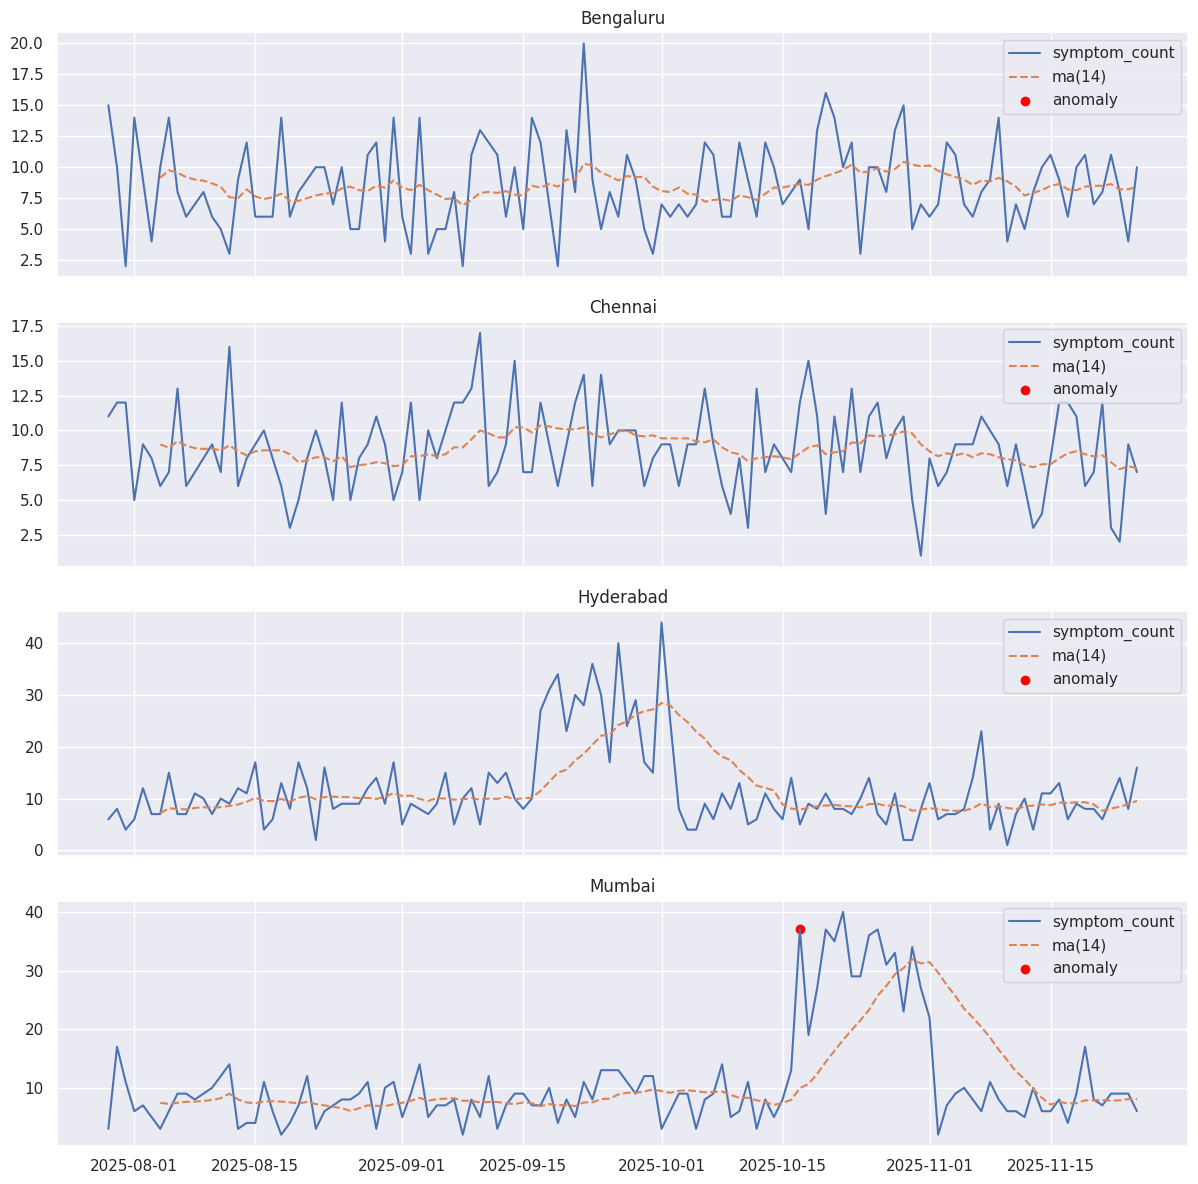

In [10]:
# Cell 10
regions = df_daily['region'].unique()
fig, axes = plt.subplots(len(regions), 1, figsize=(12, 3*len(regions)), sharex=True)
if len(regions) == 1:
    axes = [axes]
for ax, r in zip(axes, regions):
    rr = df_detected[df_detected['region']==r].copy()
    ax.plot(rr['date'], rr['symptom_count'], label='symptom_count')
    if 'symptom_count_ma' in rr.columns:
        ax.plot(rr['date'], rr['symptom_count_ma'], label='ma(14)', linestyle='--')
    ax.scatter(rr.loc[rr['anomaly'],'date'], rr.loc[rr['anomaly'],'symptom_count'], color='red', label='anomaly')
    ax.set_title(r)
    ax.legend()
plt.tight_layout()
plt.show()


In [11]:
# Cell 11

def build_ground_truth(start_date, days, outbreak_windows):
    rows=[]
    for r in [x['name'] for x in REGIONS]:
        for d in range(days):
            date = start_date + dt.timedelta(days=d)
            gt = 0
            if outbreak_windows and r in outbreak_windows:
                for s,e in outbreak_windows[r]:
                    if s <= d <= e:
                        gt = 1
            rows.append({"region": r, "date": pd.Timestamp(date), "ground_truth": gt})
    return pd.DataFrame(rows)


gt = build_ground_truth(start_date, 120, outbreak_windows)

for a in alerts:
    a["date"] = pd.Timestamp(a["date"])

df_detected['date'] = pd.to_datetime(df_detected['date'])
gt['date'] = pd.to_datetime(gt['date'])

tp=0; fp=0; fn=0
total_alerts=0; total_outbreaks=0

for r in [x['name'] for x in REGIONS]:
    gr = gt[gt['region']==r]
    total_outbreaks += gr['ground_truth'].sum()
    region_alerts = [a for a in alerts if a['region']==r]
    total_alerts += len(region_alerts)

    for idx, row in gr[gr['ground_truth']==1].iterrows():
        outbreak_date = pd.Timestamp(row['date'])
        detected_flag = any(
            (
                a['region'] == r
                and a['date'] <= outbreak_date
                and a['date'] >= (outbreak_date - pd.Timedelta(days=7))
            )
            for a in alerts
        )
        if detected_flag:
            tp += 1
        else:
            fn += 1

    for a in region_alerts:
        adate = pd.Timestamp(a['date'])
        # Look for outbreak in the next 7 days
        window = gr[(gr['date'] >= adate) & (gr['date'] <= adate + pd.Timedelta(days=7))]
        match = any(window['ground_truth'] == 1)
        if not match:
            fp += 1

precision = tp / (tp+fp) if (tp+fp)>0 else 0
recall = tp / (tp+fn) if (tp+fn)>0 else 0
f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0

print("=== Evaluation Results ===")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


=== Evaluation Results ===
True Positives: 0
False Positives: 1
False Negatives: 32
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


In [12]:
# Cell 12 — TODO notes
# Replace classifier_stub with a real LLM call (Gemini). Example pseudocode:
# from some_llm_client import LLMClient
# llm = LLMClient(api_key=os.environ['GEMINI_KEY'])
# def classifier_llm(text):
#     prompt = "Extract symptoms as JSON array and severity score (0..1) from this text: " + text
#     resp = llm.complete(prompt)
#     parsed = json.loads(resp.text)
#     return parsed
#
# Replace simulate_timeseries with actual collectors that call:
# - News APIs (NewsAPI, GDELT, RSS)
# - Google Trends (pytrends)
# - Public social streams (only public/anonymized)
#
# For forecasting, replace linear model with Prophet, ARIMA, or LightGBM ensemble for better performance.
#
# Use time-series DB for Memory Bank in production (Timescale/Postgres/BigQuery).
#
# NEVER store API keys in code. Use Kaggle Secrets / env vars / Secret Manager.


In [13]:
# Cell 13
out_path = "/kaggle/working/alerts.json"
with open(out_path, "w") as f:
    json.dump(alerts, f, default=str, indent=2)
print(f"Saved alerts to {out_path}")

readme = """
Outbreak Agent Demo
- Synthetic demo notebook that simulates signals, classifies, detects anomalies, and forecasts short-term.
- Replace the classifier_stub with an LLM or a trained symptom classifier for production.
"""
with open("/kaggle/working/README_demo.txt", "w") as f:
    f.write(readme)
print("Saved README_demo.txt")


Saved alerts to /kaggle/working/alerts.json
Saved README_demo.txt
